# Input

In [1]:
how = "first"

# Load data

In [2]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [3]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [4]:
patients.removePatientByMissingFeatures()
len(patients)

1209

## Display insight

In [5]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1209,
         'chronic_pulmonary_disease': 1209,
         'ckd_stage': 1209,
         'congestive_heart_failure': 1209,
         'dka_type': 1209,
         'gender': 1209,
         'history_aci': 1209,
         'history_ami': 1209,
         'hypertension': 1209,
         'liver_disease': 1209,
         'macroangiopathy': 1209,
         'malignant_cancer': 1209,
         'mechanical_ventilation': 1209,
         'microangiopathy': 1209,
         'oasis': 1209,
         'preiculos': 1209,
         'race': 1209,
         'saps2': 1209,
         'sofa': 1209,
         'use_NaHCO3': 1209,
         'uti': 1209,
         'ag': 1208,
         'bg': 1208,
         'bicarbonate': 1208,
         'bun': 1208,
         'egfr': 1208,
         'hr': 1208,
         'scr': 1208,
         'dbp': 1207,
         'gcs': 1207,
         'gcs_unable': 1207,
         'rr': 1207,
         'sbp': 1207,
         'phosphate': 1204,
         'calcium': 1203,
         'weight': 1191,
         'plt': 

In [6]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.3937138130686518

# Machine learning

In [7]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import auc, precision_score, recall_score, roc_curve, accuracy_score
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve( # type: ignore
        estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


def plot_calibration_curve(estimator, X, y):
    prob_pos = estimator.predict_proba(X)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y, prob_pos, n_bins=10
    )

    plt.figure(figsize=(10, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


def classification_metric_evaluate(model, X, y, binary=True, Threshold=None):
    # Predict probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]

    # For simplicity, let's assume the threshold is 0.5 if not provided
    if Threshold is None:
        Threshold = 0.5

    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= Threshold).astype(int)

    # Calculate evaluation metrics
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    # Calculate confidence intervals for AUC
    from scipy import stats

    auc_values = np.array([auc for _, auc in sorted(zip(tpr, fpr))])  # Sort AUC values
    auc_l, auc_u = stats.t.interval(
        0.95, len(auc_values) - 1, loc=np.mean(auc_values), scale=stats.sem(auc_values)
    )

    # Construct dictionary to store evaluation metrics
    metric_dic = {
        "AUC": roc_auc,
        "AUC_L": auc_l,
        "AUC_U": auc_u,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "cutoff": Threshold,  # Include the threshold in the dictionary
    }

    # Return evaluation metrics and ROC curve points
    return fpr, tpr, metric_dic, y_pred

# Split train-test

In [9]:
from sklearn.model_selection import train_test_split

splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

# XGBOOST no validate

### XGBOOST: No fill missing data

In [10]:
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from utils.prepare_data import normalizeData


a = xgb.XGBClassifier(device="cuda", n_jobs=-1)
def createXgboostModel():
    return a


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createXgboostModel()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))


print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [11:15:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Average AUC: 0.7765136360961111
Average Accuracy: 0.7286855731970784
Average Precision: 0.6780185335283778
Average Recall: 0.5904824561403509


### XGBOOST: fill missing with knn

In [11]:
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from utils.prepare_data import normalizeAndFillData, normalizeData


a = xgb.XGBClassifier(device="cuda", n_jobs=-1)


def createXgboostModel():
    return a


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createXgboostModel()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))


print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.7763821491105455
Average Accuracy: 0.7295291656664723
Average Precision: 0.6735071802848925
Average Recall: 0.6072368421052632


# XGBOOST with validate

### XGBOOST: No fill missing data

In [12]:
import xgboost as xgb
from utils.prepare_data import normalizeData


def createXgboostModel():
    return xgb.XGBClassifier(device="cuda", n_jobs=-1)

accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createXgboostModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))


print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

[0]	validation_0-logloss:0.62659
[1]	validation_0-logloss:0.61015
[2]	validation_0-logloss:0.60682
[3]	validation_0-logloss:0.59102
[4]	validation_0-logloss:0.59859
[5]	validation_0-logloss:0.58693
[6]	validation_0-logloss:0.59806
[7]	validation_0-logloss:0.60255
[8]	validation_0-logloss:0.61248
[9]	validation_0-logloss:0.61466
[10]	validation_0-logloss:0.62300
[11]	validation_0-logloss:0.62742
[12]	validation_0-logloss:0.62692
[13]	validation_0-logloss:0.63456
[14]	validation_0-logloss:0.63428
[15]	validation_0-logloss:0.63213
[16]	validation_0-logloss:0.63536
[17]	validation_0-logloss:0.64255
[18]	validation_0-logloss:0.65299
[19]	validation_0-logloss:0.65485
[20]	validation_0-logloss:0.65741
[21]	validation_0-logloss:0.65535
[22]	validation_0-logloss:0.65469
[23]	validation_0-logloss:0.66307
[24]	validation_0-logloss:0.66702
[25]	validation_0-logloss:0.66569
[26]	validation_0-logloss:0.67283
[27]	validation_0-logloss:0.68418
[28]	validation_0-logloss:0.69040
[29]	validation_0-loglos

### XGBOOST: Fill missing with k-neighbor

In [13]:
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from utils.prepare_data import normalizeAndFillData


def createXgboostModel():
    return xgb.XGBClassifier(device="cuda", n_jobs=-1)


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
metric_dic_list = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createXgboostModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))


print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

[0]	validation_0-logloss:0.61803
[1]	validation_0-logloss:0.61482
[2]	validation_0-logloss:0.59690
[3]	validation_0-logloss:0.60404
[4]	validation_0-logloss:0.60104
[5]	validation_0-logloss:0.60876
[6]	validation_0-logloss:0.60740
[7]	validation_0-logloss:0.60579
[8]	validation_0-logloss:0.60705
[9]	validation_0-logloss:0.61963
[10]	validation_0-logloss:0.63104
[11]	validation_0-logloss:0.63684
[12]	validation_0-logloss:0.64275
[13]	validation_0-logloss:0.64194
[14]	validation_0-logloss:0.64736
[15]	validation_0-logloss:0.64518
[16]	validation_0-logloss:0.64450
[17]	validation_0-logloss:0.64562
[18]	validation_0-logloss:0.64030
[19]	validation_0-logloss:0.65073
[20]	validation_0-logloss:0.65913
[21]	validation_0-logloss:0.66219
[22]	validation_0-logloss:0.67092
[23]	validation_0-logloss:0.67184
[24]	validation_0-logloss:0.67624
[25]	validation_0-logloss:0.68118
[26]	validation_0-logloss:0.68430
[27]	validation_0-logloss:0.69227
[28]	validation_0-logloss:0.69977
[29]	validation_0-loglos

### GRANDE

In [12]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [13]:
from GRANDE import GRANDE

params = {
    "depth": 5,  # tree depth
    "n_estimators": 2048,  # number of estimators / trees
    "learning_rate_weights": 0.005,  # learning rate for leaf weights
    "learning_rate_index": 0.01,  # learning rate for split indices
    "learning_rate_values": 0.01,  # learning rate for split values
    "learning_rate_leaf": 0.01,  # learning rate for leafs (logits)
    "optimizer": "adam",  # optimizer
    "cosine_decay_steps": 0,  # decay steps for lr schedule (CosineDecayRestarts)
    "loss": "crossentropy",  # loss function (default 'crossentropy' for binary & multi-class classification and 'mse' for regression)
    "focal_loss": False,  # use focal loss {True, False}
    "temperature": 0.0,  # temperature for stochastic re-weighted GD (0.0, 1.0)
    "from_logits": True,  # use logits for weighting {True, False}
    "use_class_weights": True,  # use class weights for training {True, False}
    "dropout": 0.0,  # dropout rate (here, dropout randomly disables individual estimators of the ensemble during training)
    "selected_variables": 0.8,  # feature subset percentage (0.0, 1.0)
    "data_subset_fraction": 1.0,  # data subset percentage (0.0, 1.0)
}

args = {
    "epochs": 1_000,  # number of epochs for training
    "early_stopping_epochs": 25,  # patience for early stopping (best weights are restored)
    "batch_size": 64,  # batch size for training
    "cat_idx": [],  # put list of categorical indices
    "objective": "binary",  # objective / task {'binary', 'classification', 'regression'}
    "random_seed": 42,
    "verbose": 1,
}

def createGrandeModel():
    return GRANDE(params=params, args=args)

fpr_list, tpr_list, metric_dic_list, y_pred_list = modelEvaluate(createGrandeModel)


print(f"Average AUC: {np.mean([metric['AUC'] for metric in metric_dic_list])}")
print(f"Average Accuracy: {np.mean([metric['Accuracy'] for metric in metric_dic_list])}")
print(f"Average Precision: {np.mean([metric['Precision'] for metric in metric_dic_list])}")
print(f"Average Recall: {np.mean([metric['Recall'] for metric in metric_dic_list])}")

2024-05-26 00:31:41.021505: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 00:31:41.042196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 00:31:41.480028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


KeyError: "None of [Index(['ag', 'age', 'bg', 'bicarbonate', 'bun', 'calcium',\n       'chronic_pulmonary_disease', 'congestive_heart_failure', 'dbp', 'egfr',\n       'gcs', 'gcs_unable', 'hb', 'history_aci', 'history_ami', 'hr',\n       'hypertension', 'macroangiopathy', 'malignant_cancer',\n       'mechanical_ventilation', 'microangiopathy', 'oasis', 'phosphate',\n       'plt', 'preiculos', 'rr', 'saps2', 'sbp', 'scr', 'sofa', 'use_NaHCO3',\n       'uti', 'wbc', 'weight', 'dka_type_0', 'dka_type_1', 'dka_type_2',\n       'gender_F', 'gender_M', 'race_AMERICAN INDIAN/ALASKA NATIVE',\n       'race_ASIAN', 'race_ASIAN - CHINESE', 'race_ASIAN - SOUTH EAST ASIAN',\n       'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN',\n       'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND',\n       'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - DOMINICAN',\n       'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - MEXICAN',\n       'race_HISPANIC/LATINO - PUERTO RICAN',\n       'race_HISPANIC/LATINO - SALVADORAN',\n       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_OTHER',\n       'race_PORTUGUESE', 'race_UNABLE TO OBTAIN', 'race_UNKNOWN',\n       'race_WHITE', 'race_WHITE - BRAZILIAN', 'race_WHITE - EASTERN EUROPEAN',\n       'race_WHITE - OTHER EUROPEAN', 'race_WHITE - RUSSIAN',\n       'liver_disease_MILD', 'liver_disease_NONE', 'liver_disease_SEVERE',\n       'ckd_stage_0', 'ckd_stage_1', 'ckd_stage_2', 'ckd_stage_3',\n       'ckd_stage_4'],\n      dtype='object')] are in the [columns]"

In [14]:
from tabpfn import TabPFNClassifier

def createTabPFNModel():
    return TabPFNClassifier(device="cpu", N_ensemble_configurations=32)

fpr_list, tpr_list, metric_dic_list, y_pred_list = modelEvaluate(createTabPFNModel)
print(f"Average AUC: {np.mean([metric['AUC'] for metric in metric_dic_list])}")
print(
    f"Average Accuracy: {np.mean([metric['Accuracy'] for metric in metric_dic_list])}"
)
print(
    f"Average Precision: {np.mean([metric['Precision'] for metric in metric_dic_list])}"
)
print(f"Average Recall: {np.mean([metric['Recall'] for metric in metric_dic_list])}")

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to 

Average AUC: 0.7969415098411392
Average Accuracy: 0.7410788381742739
Average Precision: 0.6969435039761553
Average Recall: 0.6031140350877193


# Legacy

# Plot curves 

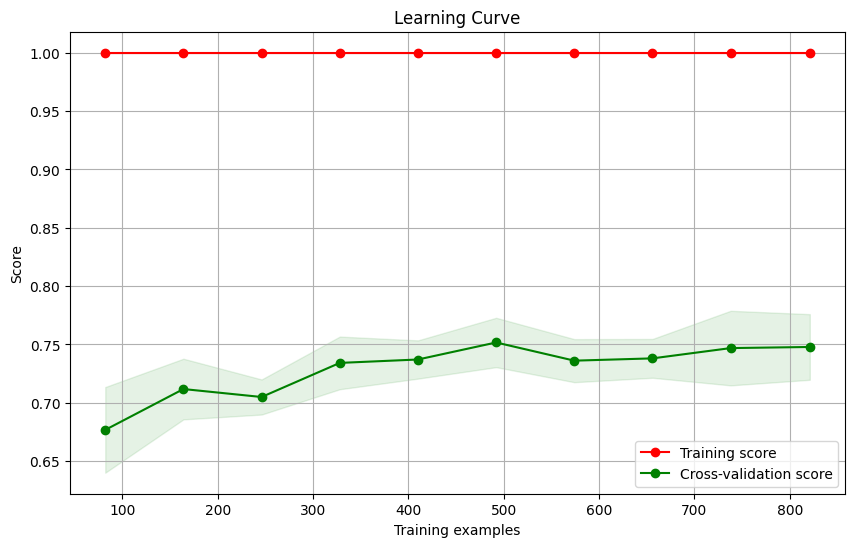

In [9]:
import xgboost as xgb

clf = xgb.XGBClassifier()

plot_learning_curve(clf, X_train, y_train)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
plot_calibration_curve(clf, X_test, y_test)

In [ ]:
from sklearn import clone
from sklearn.model_selection import StratifiedKFold

best_auc = 0.0
tprs_train, tprs_valid = [], []
fpr_train_alls, tpr_train_alls = [], []
mean_fpr = np.linspace(0, 1, 100)
KF = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
for i, (train_index, valid_index) in enumerate(KF.split(X_train, y_train)):
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
    Y_train_kf, Y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = clone(clf).fit(X_train_kf, Y_train_kf)

    fpr_train, tpr_train, metric_dic_train, _ = classification_metric_evaluate(
        model, X_train_kf, Y_train_kf,
    )
    fpr_valid, tpr_valid, metric_dic_valid, _ = classification_metric_evaluate(
        model, X_valid_kf, Y_valid_kf, Threshold=metric_dic_train["cutoff"]
    )
    metric_dic_valid.update({"cutoff": metric_dic_train["cutoff"]})

    if metric_dic_valid["AUC"] > best_auc:
        clf = model
        resThreshold = metric_dic_train["cutoff"]

    tprs_valid.append(np.interp(mean_fpr, fpr_valid, tpr_valid))
    tprs_valid[-1][0] = 0.0

    # To draw a picture, you only need plt.plot(fpr,tpr). The variable roc_auc just records the value of auc and calculates it through the auc() function.
    validationCurve =True
    if validationCurve:
        plt.plot(
            fpr_valid, tpr_valid,
            lw=1, alpha=0.4,
            label='ROC fold %4d (auc=%0.3f 95%%CI (%0.3f-%0.3f))' % (
            i + 1, metric_dic_valid['AUC'], metric_dic_valid['AUC_L'], metric_dic_valid['AUC_U']),
        )

    ##Training set ROC
    fpr_train_alls.append(fpr_train)
    tpr_train_alls.append(tpr_train)
    tprs_train.append(np.interp(mean_fpr, fpr_train, tpr_train))
    tprs_train[-1][0] = 0.0

# Cross-val with XGBoost

In [ ]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb


# Define parameters for XGBoost
params = {
    # "max_depth": 9,  # maximum depth of the tree
    # "colsample_bylevel": 1.0,
    # "colsample_bynode": 0.0,
    # "colsample_bytree": 0.23111437122462683,
    # "gamma": 0.0,
    # "learning_rate": 0.05,
    # "n_estimators": 1000,  # Set the number of boosting rounds
}

classifier = xgb.XGBClassifier(**params)

cv_scores = cross_val_score(classifier, X, y, cv=10, scoring="recall")


# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean accuracy:", mean_accuracy)

In [ ]:
predictions = classifier.predict(X_test)
predictions

In [9]:
# Evaluate the model
from sklearn.metrics import classification_report


accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print(classification_report(y_test, predictions))

In [17]:
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test, predictions)

# Plot confusion matrix
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted Negative", "Predicted Positive"],
    yticklabels=["Actual Negative", "Actual Positive"],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

# Hyperparams tune

In [18]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score


# Define your XGBoost model
model = XGBClassifier()

# Define the parameter grid to search through
param_grid = {
    "max_depth": [8, 9, 10],  # Maximum tree depth
    "learning_rate": [0.1, 0.05, 0.01],  # Learning rate
    "n_estimators": [500, 800, 100],  # Number of trees
}

# Define a custom scoring function to optimize for minimizing false negatives
scorer = make_scorer(recall_score, pos_label=1)

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid,
    # scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_params

In [14]:
# Train the model with the best parameters
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, predictions)
print("F1 Score:", f1)

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

# LassoCV

In [16]:
from sklearn.linear_model import LassoCV
import pandas as pd

# Feature selection using LassoCV
lasso_cv = LassoCV(cv=5, random_state=7)
lasso_cv.fit(X, y)
selected_features = X.columns[lasso_cv.coef_ != 0]

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame({"column_name": X.columns, "lasso_coef": lasso_cv.coef_}).T)

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


# Splitting data into training and validation cohorts
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "XGBClassifier": XGBClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LGBMClassifier": LGBMClassifier(),
    "SVC": SVC(),
    "MLPClassifier": MLPClassifier(),
    "GaussianNB": GaussianNB(),
    "ComplementNB": ComplementNB(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "BaggingClassifier": BaggingClassifier(),
}

# Perform cross-validation and evaluate each model
results = {}
for clf_name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=10)
    results[clf_name] = scores.mean()

# Print results
for clf_name, score in results.items():
    print(f"{clf_name}: {score}")

# Other

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
import xgboost as xgb

estimators = [
    ("encoder", TargetEncoder()),
    ("clf", xgb.XGBClassifier(random_state=8)),
]

pipe = Pipeline(steps=estimators, verbose=True)
pipe

In [29]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer


searchSpace = {
    "clf__max_depth": Integer(5, 11),
    "clf__learning_rate": Real(0.001, 1.0, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.0, 0.5),
    "clf__colsample_bylevel": Real(0.5, 1.0),
    "clf__colsample_bynode": Real(0.0, 0.5),
    "clf__reg_alpha": Real(0.0, 10.0),
    "clf__reg_lambda": Real(0.0, 10.0),
    "clf__gamma": Real(0.0, 10.0),
}

opt = BayesSearchCV(
    pipe, search_spaces=searchSpace, cv=3, n_iter=50, scoring="roc_auc", random_state=7
)

opt.fit(X, y)

In [32]:
opt.best_estimator_

In [30]:
opt.best_score_

In [31]:
opt.score(X_test, y_test)

In [ ]:
opt.best_estimator_.steps